Data source: http://insideairbnb.com/get-the-data.html (Chicago) <br>
1) calendar.csv - Information about the availability calendar for each listing<br>
2) listings.csv - Detailed listings data, including various features of each listing such as number of bedrooms, bathrooms, etc. <br>

Goal: <br>
1) Predicting of Airbnb listing prices <br>
2) Analyze which variables would affect AirBnB rentals <br>
Based on these results, hosts are provided with the pricing strategy while guests would more understand how to choose their desirable rentals. <br>

Outline: <br>
1) Exploratory data analysis of the calendar data <br>
2) Exploratory data analysis of the listing data <br>
3) Data preprocessing and feature creation/selection of the listing data <br>
4) Model building based on the listing data with several regressors <br>
5) Model tuning <br>
6) Feature importance <br>

In [882]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import seaborn as sns
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
cwd=os.getcwd()

pd.set_option('display.max_columns', 150)

# Calendar data

In [883]:
cld=pd.read_csv('calendar.csv')
print(cld.head(2))
print(cld.shape)

   listing_id        date available    price adjusted_price  minimum_nights  \
0     1278457  2019-02-09         f  $550.00        $550.00               5   
1      479086  2019-02-09         t   $20.00         $20.00               1   

   maximum_nights  
0            1125  
1              33  
(2848095, 7)


- Time range of the calendar data

In [884]:
print("From "+cld.date.min()+" to "+cld.date.max())

From 2019-02-09 to 2020-02-08


 > Note: Calendar data covers one year time frame, which is available to the next year.

In [885]:
# remove '$' and ',' in price, eg. $1,244.00'
array1=['price', 'adjusted_price']
for i in array1:
    cld[i]=cld[i].str.replace('$','')
    cld[i]=cld[i].str.replace(',','') 
    cld['price'] = cld['price'].astype(float) 

In [886]:
# check if there are null values and remove them
print(cld.isnull().sum())
cld.dropna(subset = ['price'], inplace=True) 
print(cld.isnull().sum())

listing_id          0
date                0
available           0
price             171
adjusted_price    171
minimum_nights      0
maximum_nights      0
dtype: int64
listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64


- Explore the distribution of the price from the calendar data 

Skewness: 18.331984
Kurtosis: 541.059609


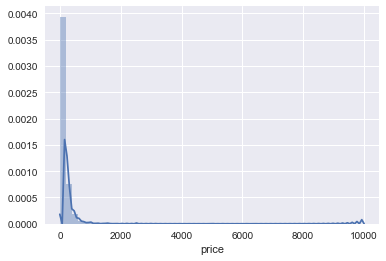

<Figure size 432x288 with 0 Axes>

In [887]:
sns.distplot(cld['price'])
fig = plt.figure()
print("Skewness: %f" % cld['price'].skew())
print("Kurtosis: %f" % cld['price'].kurt())

> Note: There are some outliers where the prices are more than 2000 USD up to 10000 USD

 - Explore listing prices in each month

In [888]:
split=pd.DataFrame()
split['year']=pd.to_datetime(cld['date']).dt.year
split['month']=pd.to_datetime(cld['date']).dt.month
split['dayofweek']=pd.to_datetime(cld['date']).dt.dayofweek
new_cld=cld.join(split, on=None,how='left',sort=False)

In [889]:
new_cld.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek
0,1278457,2019-02-09,f,550.0,550.00,5,1125,2019,2,5
1,479086,2019-02-09,t,20.0,20.00,1,33,2019,2,5
2,479086,2019-02-10,t,20.0,20.00,1,33,2019,2,6
3,479086,2019-02-11,t,20.0,20.00,1,33,2019,2,0
4,479086,2019-02-12,t,20.0,20.00,1,33,2019,2,1


- Boxplot of the price in each month with outliers removed

Text(0.5,1,'Listing Price by Month')

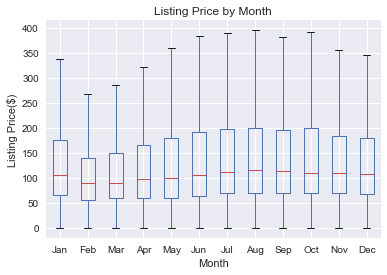

In [890]:
price_month=new_cld[['month','price']]
price_month_mean=price_month.groupby('month').mean()
price_month1=price_month.pivot(columns='month',values='price')
plot2=price_month1.boxplot(sym="")
ticks = list(range(1, 13, 1))
labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
plt.xticks(ticks, labels);
plot2.set_xlabel('Month')
plot2.set_ylabel('Listing Price($)')
plot2.set_title('Listing Price by Month')

> Note: Apparently Airbnb prices in August and October are more expensive. 

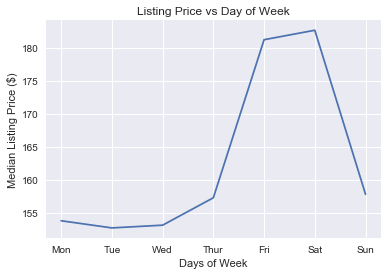

In [891]:
dd = [ 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
price_week = new_cld.groupby('dayofweek')['price'].mean()
plot2=price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
plt.xticks(ticks, dd)
plot2.set_xlabel('Days of Week')
plot2.set_ylabel('Median Listing Price ($)')
plot2.set_title('Listing Price vs Day of Week')
plot2
#plt.show()

> Listing prices on Friday and Saterday are relatively higer

- Summary <br>
If you are traveling on budget and still interested in visiting Chicago, it could be better to visit there on weekdays and avoid both August or September.

# Listing Data

In [892]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [893]:
ld=pd.read_csv('listings.csv')

In [894]:
# remove '$' and ',' in different types of prices 
array1=['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for i in array1:
    ld[i]=ld[i].str.replace('$','')
    ld[i]=ld[i].str.replace(',','')
    ld[i]=pd.to_numeric(ld[i], errors='coerce') 

In [895]:
# drop rows with weird values, as these values should not be zero
array1=['bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price']
for i in array1:
    ld = ld[ld[i] != 0]

- First, take a look at the distribution of the price in different regions in Chicago

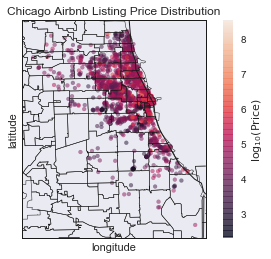

In [896]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\Fangyu\OneDrive\4project\airbnb_chicago_new'

# get the price, latitude and longtitude data
df_map=ld[['price', 'latitude', 'longitude']]
df_map.dropna(inplace=True)
df_map['price']=np.log(df_map['price'])

df_map.price
df_map.describe()
df_maploc = df_map[np.abs(df_map.price-df_map.price.mean())<=(3*df_map.price.std())]

# Ploting those distributions
import os
os.environ['PROJ_LIB'] = r'C:\Users\Fangyu\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap, cm

# set the latitude/longitude boundary of the maps
long_max = df_map['longitude'].max() + 0.02
long_min = df_map['longitude'].min() - 0.02
mid_long = (df_map['longitude'].min() + df_map['longitude'].max())/2

lat_max = df_map['latitude'].max() + 0.02
lat_min = df_map['latitude'].min() - 0.02
mid_lat = (df_map['latitude'].min() + df_map['latitude'].max())/2

df_map2 = df_map.sample(frac=0.25)
m = Basemap(projection='cyl',lat_0=mid_lat,lon_0=mid_long,\
            llcrnrlat=lat_min,urcrnrlat=lat_max,\
            llcrnrlon=long_min,urcrnrlon=long_max,\
            resolution='h',area_thresh=10)
m.drawcoastlines()
m.drawstates()
m.shadedrelief()
m.drawmapboundary()

x1, y1 = m(df_map2['longitude'], df_map2['latitude'])
sp = plt.scatter(x1, y1, c=df_map2['price'], s=15,alpha=0.5)

# load the shape file 
# shape file can be obtained from https://www.census.gov/
us_shape_file_dir = r'C:\Users\Fangyu\OneDrive\4project\airbnb_chicago_new\cb_2017_us_zcta510_500k'
os.chdir(us_shape_file_dir)
shp_info = m.readshapefile(os.path.basename(us_shape_file_dir), 'state')

cb1 = plt.colorbar(sp, label=r'$\log_{10}({\rm Price})$')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Chicago Airbnb Listing Price Distribution')
plt.show()

# set the os to cwd
os.chdir(cwd)

- Summary of the price statistics

In [897]:
#print(ld.price.describe())
#print(ld.isnull().sum())

- Exploring the price

count     7145.000000
mean       142.180266
std        225.234295
min         10.000000
25%         60.000000
50%         99.000000
75%        160.000000
max      10000.000000
Name: price, dtype: float64
Skewness: 19.827257
Kurtosis: 672.536078
count    7.145000e+03
mean              inf
std               NaN
min      2.202647e+04
25%      1.142007e+26
50%      9.889030e+42
75%      3.069850e+69
max               inf
Name: price, dtype: float64
Skewness: 0.076255
Kurtosis: 0.970346


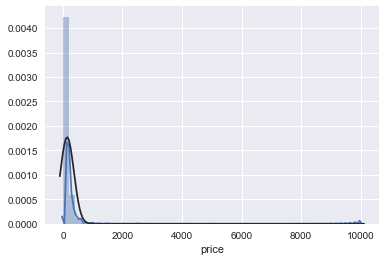

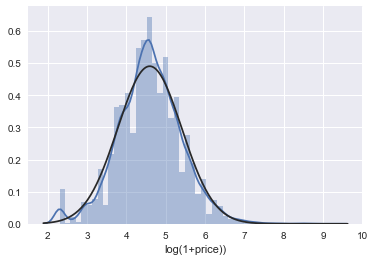

<Figure size 432x288 with 0 Axes>

In [898]:
from scipy.stats import norm
import scipy

sns.distplot(ld['price'], fit=norm);
fig = plt.figure()
print(ld['price'].describe())
print("Skewness: %f" % ld['price'].skew())
print("Kurtosis: %f" % ld['price'].kurt())

sns.distplot(np.log(ld['price']), fit=norm);
plt.xlabel("log(1+price))")
fig = plt.figure()
#res = scipy.stats.probplot(check['price'], plot=plt)
print(np.exp(ld['price']).describe())
print("Skewness: %f" % np.log(ld['price']).skew())
print("Kurtosis: %f" % np.log(ld['price']).kurt())

> Note: The price is skew from the distribution and there are outliers; and regression could be thrown off very easily by extreme values. To deal with the skew data, log transformation will be used used in modeling

Text(0,0.5,'listing price')

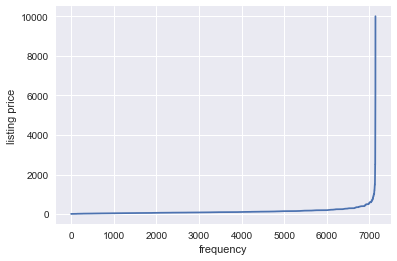

In [899]:
ld['price'].sort_values().reset_index(drop=True).plot()
plt.xlabel('frequency')
plt.ylabel('listing price')

> Note: Those extremely high-value rentals may sometimes be actual mansions etc. or just joke listings. These data will throw off the model if included. To avoid this issue, 1) we can remove those outliers by using the 3z upper bound of the listing price ($817 USD) or more strict criteria; or 2) use log transformation of the listing price to make it normal distributed.

In [900]:
# To remove outliers, ie. listing prices larger than 3z ~ $817 USD
# z-score greater than 3 std is considered to be an outlier.
def remove_outlier_z(df_in, col_name):
    mean= df_in[col_name].mean()
    stdv= df_in[col_name].std()
    
    np.log(ld['price'])
   # df_out = df_in.loc[(df_in[col_name] > mean - stdv*3 ) & (df_in[col_name] < mean + stdv*3 )]
    df_out = df_in.loc[ (df_in[col_name] < mean + stdv*3 )]
    upper= mean + stdv*3
    print("upper bound "+str(round(upper,2)))
    return df_out
#ld2 = remove_outlier_z(ld, 'price')
#ld = ld.query('price <= 600')

- Log transformation of the listing prices

In [901]:
ld2['price']=np.log1p(ld['price'])

Text(0,0.5,'log(1+price))')

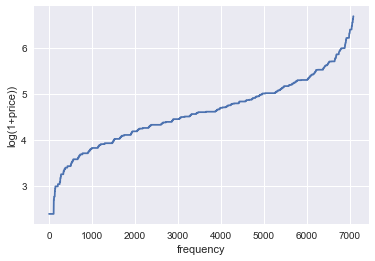

In [902]:
ld2['price'].sort_values().reset_index(drop=True).plot()
plt.xlabel('frequency')
plt.ylabel('log(1+price))')

- Distribution of listing prices after removing outliers

Text(0.5,1,'Histogram of listing prices')

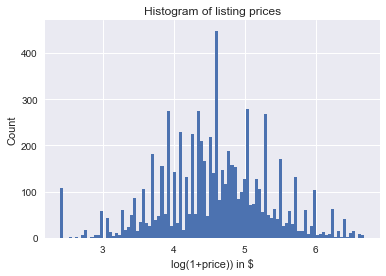

In [903]:
ld2.price.hist(bins=100)
plt.ylabel('Count')
plt.xlabel('log(1+price)) in $')
plt.title('Histogram of listing prices')

- Explore the percentages of missing values 

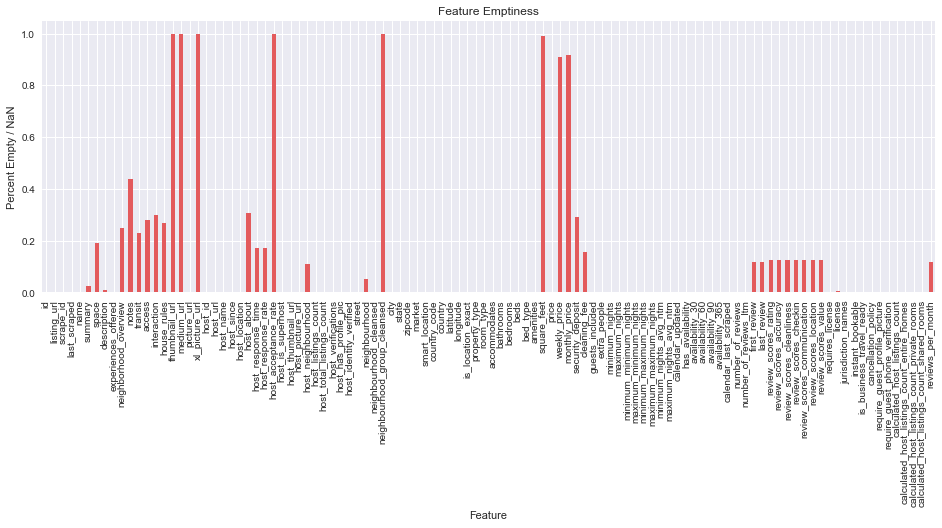

In [904]:
percentage_missing_data = ld2.isnull().sum() / ld2.shape[0]
ax = percentage_missing_data.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
plt.show()
#print(percentage_missing_data[percentage_missing_data>0.3])

last_scraped                        0.000141
experiences_offered                 0.000141
host_response_time                  0.000564
host_is_superhost                   0.000282
host_has_profile_pic                0.000282
host_identity_verified              0.000282
street                              0.001975
city                                0.001552
state                               0.000282
market                              0.000423
smart_location                      0.001975
country_code                        0.000141
country                             0.000141
is_location_exact                   0.000282
property_type                       0.003527
room_type                           0.000423
bed_type                            0.000705
has_availability                    0.000141
calendar_last_scraped               0.000141
requires_license                    0.000282
jurisdiction_names                  0.000705
instant_bookable                    0.000282
is_busines

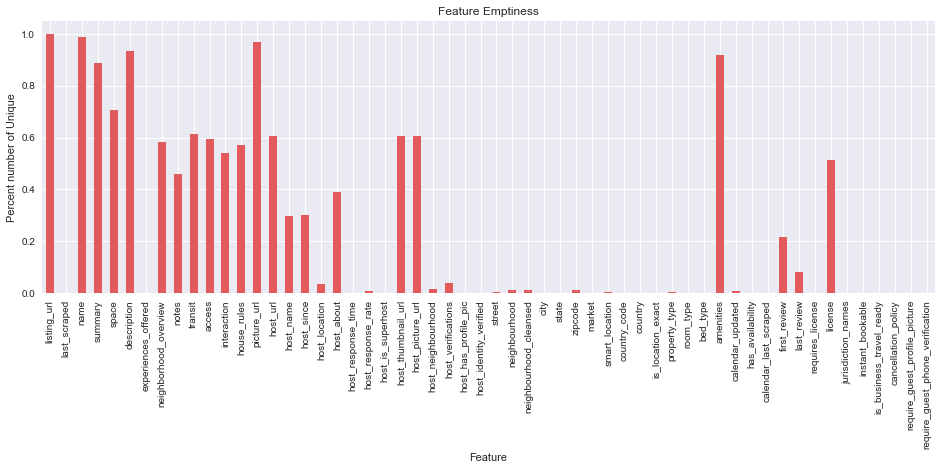

In [905]:
## for those have high unique percentage 
categories = ld2.columns[ld2.dtypes == 'object']
percentage_unique = ld2[categories].nunique() / ld2.shape[0]
ax = percentage_unique.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent number of Unique')
ax.set_title('Feature Emptiness')
print(percentage_unique[percentage_unique<0.005])

> Note: The categorical features having fewer NaN values and having more unique categories can be considered in modeling. ie. to reduce features, drop almost all of the same categorical value/level). (text features are not used in this example, and can be used by NLP) 

- Exploring categorical features vs prices

<Figure size 864x432 with 0 Axes>

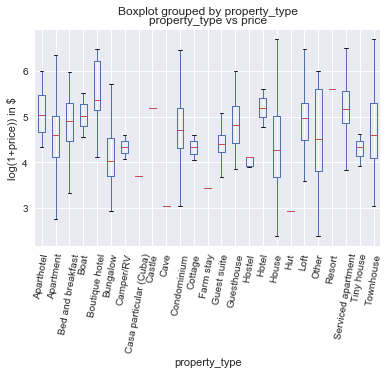

In [906]:
# boxplot of property_type vs price
plt.figure(figsize = (12, 6))
ld2.boxplot('price', 'property_type', rot=80)
plt.ylabel('log(1+price)) in $')
plt.title("property_type vs price")
plt.show()

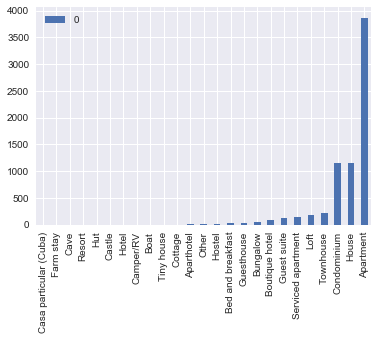

In [907]:
# frequency of perperty_type
nb_counts = Counter(ld2.property_type)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

Text(0.5,1,'room_type vs price')

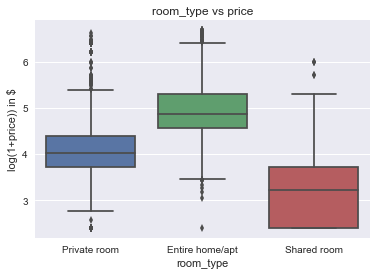

In [908]:
# boxplot of room_type
sns.boxplot(x = 'room_type', y = 'price',  data = ld2)
xt = plt.xticks(rotation=0)
plt.ylabel('log(1+price)) in $')
plt.title("room_type vs price")

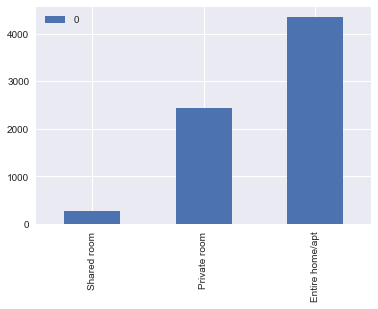

In [909]:
# frequency of room_type
nb_counts = Counter(ld2.room_type)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

Text(0.5,1,'neighbourhood_cleansed vs price')

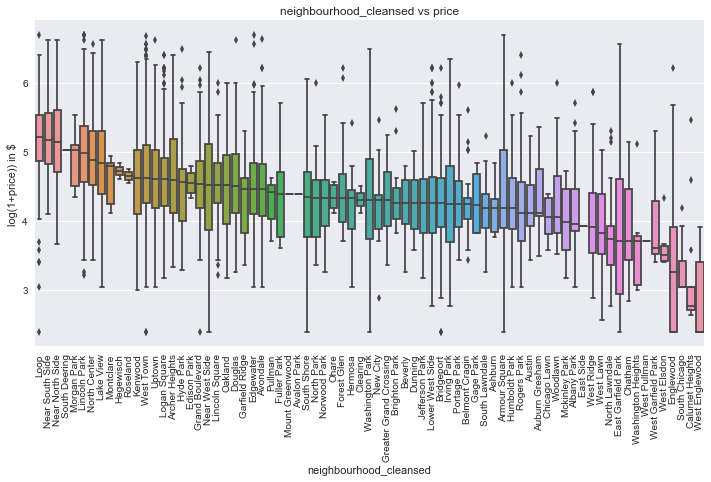

In [910]:
# neighbourhood_cleansed vs price
sort_price = ld2.groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'neighbourhood_cleansed', y = 'price',  data = ld2, order=sort_price)
xt = plt.xticks(rotation=90)
plt.ylabel('log(1+price)) in $')
plt.title("neighbourhood_cleansed vs price")

> The Loop, Near South Side nad Near North Side neighbourhood show relatively higher listing prices

In [911]:
# Create a boxplot of zipcode
# ld2.boxplot('price', 'zipcode', rot=60)
# plt.show()

Text(0.5,1,'cancellation_policy vs price')

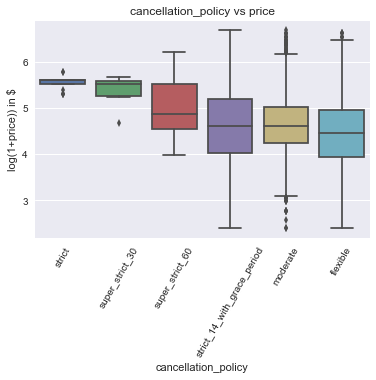

In [912]:
# boxplot of cancellation_policy vs price
sort_price = ld2.groupby('cancellation_policy')['price'].median().sort_values(ascending=False).index
sns.boxplot(x = 'cancellation_policy', y = 'price',  data = ld2, order=sort_price)
xt = plt.xticks(rotation=60)
plt.ylabel('log(1+price)) in $')
plt.title("cancellation_policy vs price")

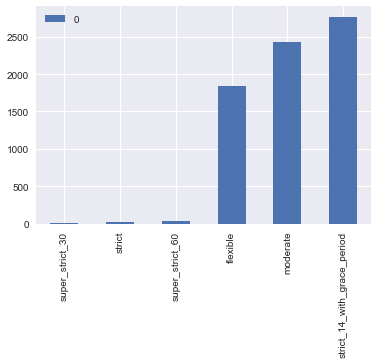

In [913]:
# frequency of cancellation_policy
nb_counts = Counter(ld2.cancellation_policy)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

Text(0,0.5,'log(1+price)) in $')

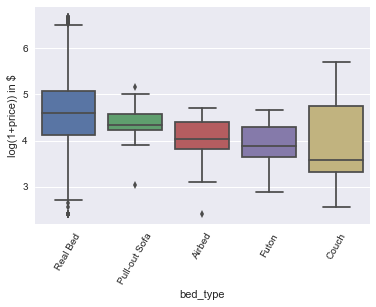

In [914]:
# boxplot of bed_type vs price
sort_price = ld2.groupby('bed_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(x = 'bed_type', y = 'price',  data = ld2, order=sort_price)
xt = plt.xticks(rotation=60)
plt.ylabel('log(1+price)) in $')

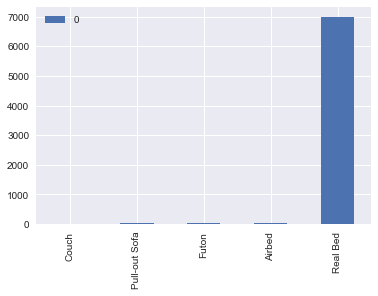

In [915]:
# frequency of bed_type
nb_counts = Counter(ld2.bed_type)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

Text(0,0.5,'log(1+price)) in $')

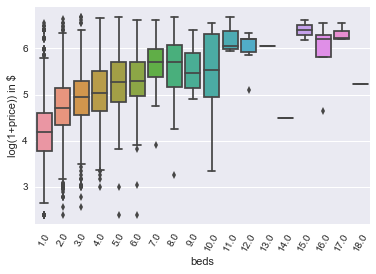

In [916]:
# boxplot of number of bed vs price
#sort_price = ld.groupby('beds')['price'].median().sort_values(ascending=False).index
sns.boxplot(x = 'beds', y = 'price',  data = ld2)
xt = plt.xticks(rotation=60)
plt.ylabel('log(1+price)) in $')

- Explore numeric features

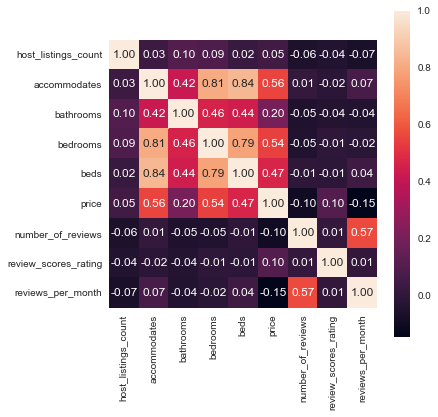

In [917]:
# explore correlation of selected numeric features
col = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']
corr = ld2[col].corr()
plt.figure(figsize = (6,6))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

> Note: number of bedrooms and accommodates seem to be correlated with the log transformed price

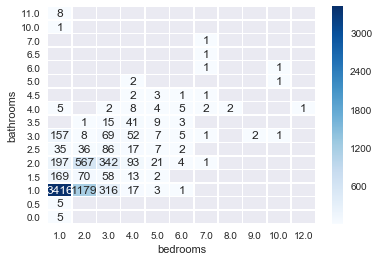

In [918]:
sns.heatmap(ld2.groupby(['bathrooms', 'bedrooms']).count()['price'].reset_index().pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False),
            cmap="Blues", fmt='.0f', annot=True, linewidths=0.5)
plt.show()

> Note: Majority of listings have one bedroom and one bathroom

# Data preprocessing and feature selection/creation

In [919]:
ld3=ld2.copy()

In [920]:
categ_tf_features= ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_phone_verification', 'require_guest_profile_picture', 'require_guest_phone_verification']

for tf_feature in categ_tf_features:
    ld3[tf_feature] = ld3[tf_feature].map(lambda s: 0 if s == "f" else 1)

In [921]:
# selected features used for modeling
ld3 = ld3[['host_is_superhost', 'host_identity_verified', 
          'instant_bookable', 'require_guest_profile_picture','require_guest_phone_verification', 
          'security_deposit', 'cleaning_fee',  'host_total_listings_count', 'minimum_nights',
          'bathrooms', 'bedrooms', 'guests_included', 'availability_30', 
           'number_of_reviews', 'review_scores_rating', 'reviews_per_month', 
           'room_type', 'cancellation_policy', 'neighbourhood_cleansed', 'price']]

# not used: 'bed_type', 'property_type', 'is_location_exact', 'requires_license', 'host_has_profile_pic','host_listings_count'

In [922]:
# get dummy for selected categorical features
nc_dummies = pd.get_dummies(ld3.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(ld3.room_type)
cp_dummies = pd.get_dummies(ld3.cancellation_policy)

df= pd.concat((ld3.drop(['neighbourhood_cleansed', 'room_type', 'cancellation_policy'], axis=1),
                     nc_dummies.astype(int), rt_dummies.astype(int), cp_dummies.astype(int)), axis=1)


- fill NaN with median values

In [923]:
for col in df.columns[df.isnull().any()]:
    df[col] = df[col].fillna(df[col].median())

- prepare target, training and testing data

In [924]:
# note the price is already log transformed
y=df['price']
X=df.drop('price', axis='columns')

# Model building

In [925]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from collections import Counter
from sklearn.model_selection import train_test_split

In [926]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , random_state=5)

In [927]:
rs = 1
ests = [ LinearRegression(),  
        Ridge(random_state=rs),
        Lasso(random_state=rs), 
        ElasticNet(random_state=rs),
        BayesianRidge(),
        OrthogonalMatchingPursuit(), 
        RandomForestRegressor(random_state=rs),
        GradientBoostingRegressor(random_state=rs),
        XGBRegressor(random_state=rs)]

ests_labels = np.array([ 'Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP', 'RF', 'GB', 'XGBR'])
errvals = np.array([])
scvals = np.array([])

for e in ests:
    e.fit(X_train, y_train)
    this_err = median_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)
    
    y_pred = e.predict(X_test)
    r2score = r2_score(y_test, y_pred)
    scvals = np.append(scvals, r2score)

[Text(0,0,'Lasso'),
 Text(0,0,'ElasticNet'),
 Text(0,0,'OMP'),
 Text(0,0,'BayesRidge'),
 Text(0,0,'Ridge'),
 Text(0,0,'Linear'),
 Text(0,0,'XGBR'),
 Text(0,0,'GB'),
 Text(0,0,'RF')]

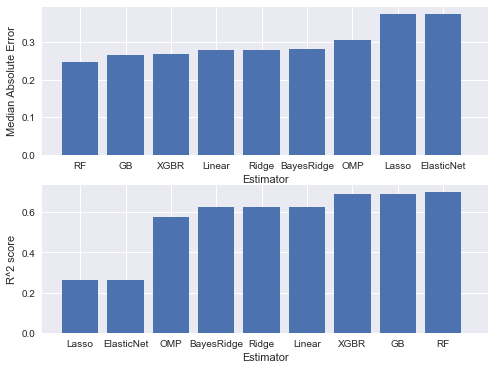

In [928]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
# plot mean_squared_error obtained from different models
pos = np.arange(errvals.shape[0])

srt = np.argsort(errvals)
axes[0].bar(pos, errvals[srt], align='center')
axes[0].set_xlabel('Estimator')
axes[0].set_ylabel('Median Absolute Error')
axes[0].set_xticks(np.arange(0,10))
axes[0].set_xticklabels(ests_labels[srt])

# plot R^2 obtained from different models
pos2 = np.arange(scvals.shape[0])
srt2 = np.argsort(scvals)
axes[1].bar(pos2, scvals[srt2], align='center')
axes[1].set_xlabel('Estimator')
axes[1].set_ylabel('R^2 score')
axes[1].set_xticks(np.arange(0,10))
axes[1].set_xticklabels(ests_labels[srt2])



 > RF, GB, or XGRB performs better than other models

# Model tuning and feature importances

- Randomforest

In [930]:
from sklearn.model_selection import GridSearchCV
clf=RandomForestRegressor(random_state=123)

# Create the hyperparameter grid
n_est=300
param_grid = { "n_estimators": [ 300 ],
              "max_depth": [3, 5, 10],
               "max_features":["log2","sqrt", "auto"]}

# Call GridSearchCV
grid_search_rf = GridSearchCV(clf, param_grid, cv=3)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Print best parameters
print("best parameters: ", grid_search_rf.best_params_)

best parameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300}


In [931]:
err = median_absolute_error(y_test, grid_search_rf.best_estimator_.predict(X_test))
print('Median Absolute Error of RandomForestRegressor+GridSearchCV: ', round(err, 2))


Median Absolute Error of RandomForestRegressor+GridSearchCV:  0.25


- Feature importance from RandomForestRegressor+GridSearchCV

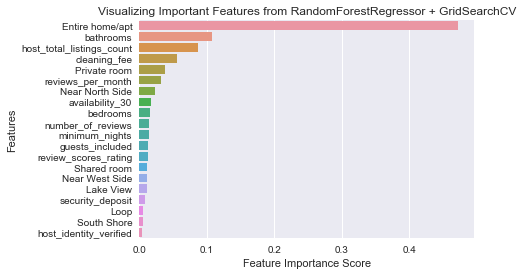

<Figure size 360x360 with 0 Axes>

Entire home/apt              0.472487
bathrooms                    0.108076
host_total_listings_count    0.086519
cleaning_fee                 0.055961
Private room                 0.038169
reviews_per_month            0.032841
Near North Side              0.023826
availability_30              0.017150
bedrooms                     0.015450
number_of_reviews            0.013975
minimum_nights               0.013668
guests_included              0.013549
review_scores_rating         0.013385
Shared room                  0.012024
Near West Side               0.011165
Lake View                    0.010636
security_deposit             0.007921
Loop                         0.005616
South Shore                  0.004808
host_identity_verified       0.003533
dtype: float64


In [932]:
feature_imp_rf = pd.Series(grid_search_rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_rf[:20], y=feature_imp_rf[:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features from RandomForestRegressor + GridSearchCV")
plt.figure(figsize=(5,5))
plt.show()
print(feature_imp_rf[:20])

- Gradient Boosting 

In [933]:
from sklearn.model_selection import GridSearchCV
clf=GradientBoostingRegressor(random_state=123)

# Create the hyperparameter grid

param_grid = {
    "n_estimators": [ 300 ],
    "max_depth": [3, 5, 10],
    "learning_rate": [ 0.1, 0.05, 0.01 ],
    "loss" : [ 'ls', 'lad' ]
}

# Call GridSearchCV
grid_search_gb = GridSearchCV(clf, param_grid, cv=3)

# Fit the model
grid_search_gb.fit(X_train, y_train)

# Print best parameters
print("best parameters: ", grid_search_gb.best_params_)

best parameters:  {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'n_estimators': 300}


In [934]:
err_gb = median_absolute_error(y_test, grid_search_gb.best_estimator_.predict(X_test))
print('Median Absolute Error of GradientBoostingRegressor+GridSearchCV: ', round(err_gb, 2))

Median Absolute Error of GradientBoostingRegressor+GridSearchCV:  0.24


- Feature importance from GradientBoostingRegressor+GridSearchCV

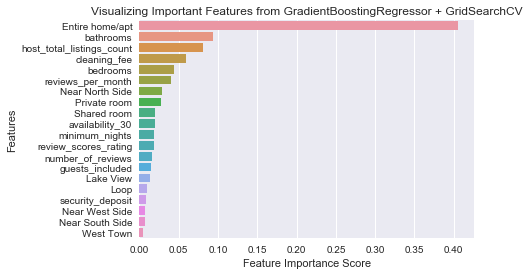

<Figure size 360x360 with 0 Axes>

Entire home/apt              0.405602
bathrooms                    0.093284
host_total_listings_count    0.081400
cleaning_fee                 0.059463
bedrooms                     0.044729
reviews_per_month            0.040326
Near North Side              0.028631
Private room                 0.027171
Shared room                  0.020133
availability_30              0.020061
minimum_nights               0.018316
review_scores_rating         0.018146
number_of_reviews            0.016517
guests_included              0.015156
Lake View                    0.012971
Loop                         0.010133
security_deposit             0.009020
Near West Side               0.007326
Near South Side              0.006879
West Town                    0.004912
dtype: float64


In [935]:
feature_imp_gb = pd.Series(grid_search_gb.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_gb[:20], y=feature_imp_gb[:20].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features from GradientBoostingRegressor + GridSearchCV")
plt.figure(figsize=(5,5))
plt.show()
print(feature_imp_gb[:20])

> The results here are somewhat intuitive. We can see that some of the variables have more influence than others, with the most influential feature to be the 'Entire home/apt' attribute, indicating that whether or not the unit is shared with other people would affect the most in setting the price. As for neighbourhood, the Near North Side feature also scored higher than other regions, which corresponds to the observation in EDA of the neighbourhoods vs prices

# Conclusion

In this project, the analysis of the calendar and listing data of Airbnb in Chicago were performed. Based on the analysis of calendar data, if you are traveling on budget and still interested in visiting Chicago, it might be better to visit there on weekdays and avoid both August or September. To build a rental predictor, different ensemble methods were demonstrated, from which RandomForestRegressor, GradientBoostingRegressor, or XGBRegressor would have better results than other individual estimators. With hyperparameter tuning using GridSearchCV, RandomForestRegressor and GradientBoostingRegressor would yield better results. Finally, influential features are provided, such that hosts could include them in the pricing strategy while guests are provided with information to choose their ideal rental.